In [1]:
#Includes necesarios
from sklearn.naive_bayes import GaussianNB,CategoricalNB,MultinomialNB

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import train_test_split

from auxiliar import get_train_set,get_holdout_set,create_prediction
import preprocessing as pr

from auxiliar import plot_cm,plot_tree
from sklearn.metrics import classification_report,plot_roc_curve

# **Naive Bayes**

Obtenemos el dataset con el cual entrenaremos nuestro modelo. Para este modelo se opto unicamente tratar los missings como categoricos:

In [2]:
X,y = get_train_set()
X = pr.feature_engineering(X)

## GaussianNB

Para aplicar este tipo de modelo debemos quedarnos solo con las columnas continuas. En este caso no nos hace falta aplicar OHE, puesto que todas las columnas que nos quedan son numericas. Tampoco nos sirve los preprocesamientos de reduccion o discretizacion puesto que esto eliminaria o generaria nuevas columnas categoricas.

In [30]:
X_continuos = pr.select_types(X,types=['int64','int32'])
X_continuos.head()

,anios_estudiados,edad,ganancia_perdida_declarada_bolsa_argentina,horas_trabajo_registradas
0,17,39,2174,40
1,17,50,0,13
2,13,38,0,40
3,11,53,0,40
4,17,28,0,40


Partimos nuestro set en *train* y *validation*:

In [31]:
X_train, X_validation, y_train, y_validation = train_test_split(X_continuos,y, test_size=0.2, stratify=y)

Busco los mejores hiperparametros para el arbol de decision con GridSearchCV. La metrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.

In [32]:
parameters = {
}

clf = GaussianNB()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")
print("------------------")
print(f"Score in Validation: {gscv.score(X_validation, y_validation)}")

Best score: 0.836715626893724
Best params {}
------------------
Score in Validation: 0.834598375497823


Armo el modelo de arbol de decision con los hiperparametros calculados:

In [33]:
model_gaussianNB = gscv.best_estimator_
model_gaussianNB

GaussianNB()

Predigo con el validation set:

In [34]:
nb_predict = model_gaussianNB.predict(X_validation)

**Metricas**

In [35]:
print(classification_report(y_validation, nb_predict))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      4945
           1       0.76      0.23      0.35      1568

    accuracy                           0.80      6513
   macro avg       0.78      0.60      0.61      6513
weighted avg       0.79      0.80      0.75      6513



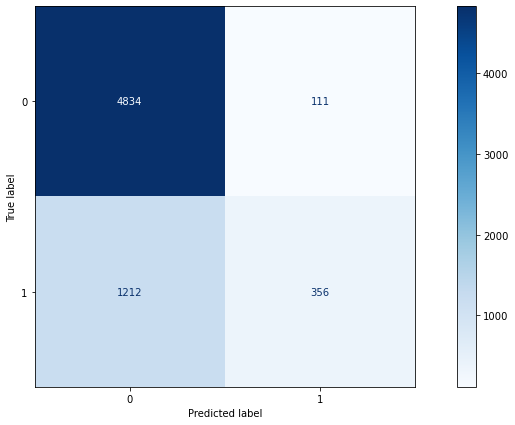

In [36]:
plot_cm(model_gaussianNB, X_validation, y_validation)

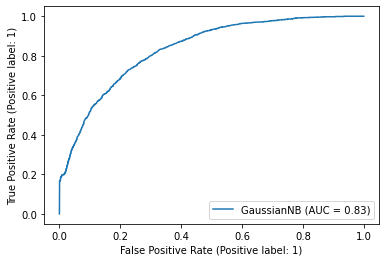

In [37]:
plot_roc_curve(model_gaussianNB, X_validation, y_validation, response_method="predict_proba")
plt.show()

## CategoricalNB

Para aplicar este tipo de modelo debemos quedarnos solo con las columnas categoricas.

In [38]:
X_category = pr.select_types(X,types=['category'])
X_category.head()

,barrio,categoria_de_trabajo,estado_marital,genero,religion,rol_familiar_registrado,trabajo
0,palermo,empleado_provincial,sin_matrimonio,hombre,cristianismo,sin_familia,entretenimiento
1,palermo,monotributista,matrimonio_civil,hombre,cristianismo,casado,directivo_gerente
2,palermo,relacion_de_dependencia,divorciado,hombre,cristianismo,sin_familia,limpiador
3,palermo,relacion_de_dependencia,matrimonio_civil,hombre,judaismo,casado,limpiador
4,balvanera,relacion_de_dependencia,matrimonio_civil,mujer,judaismo,casada,profesional_especializado


Luego debemos aplicar OHE a las columnas ya que nuestro modelo solo entiende valores numericos:

In [39]:
pr.init_OHE(X_category)
X_category_ohe = pr.apply_OHE(X_category)

Partimos nuestro set en *train* y *validation*:

In [40]:
X_train, X_validation, y_train, y_validation = train_test_split(X_category_ohe,y, test_size=0.2, stratify=y)

Busco los mejores hiperparametros para el arbol de decision con GridSearchCV. La metrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.

In [41]:
parameters = {
    'alpha': np.arange(0, 1,0.01),
}

clf = MultinomialNB()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")
print("------------------")
print(f"Score in Validation: {gscv.score(X_validation, y_validation)}")

Best score: 0.8313133295910413
Best params {'alpha': 0.4}
------------------
Score in Validation: 0.837170869358866


### Preprocesamiento: Discretizacion

Ahora vemos que pasa si discretizamos las columnas numericas del dataset original.

In [4]:
X_discretized = pr.discretize_columns(X)
X_discretized.head()

,barrio,categoria_de_trabajo,estado_marital,genero,religion,rol_familiar_registrado,trabajo,anios_estudiados_bins,edad_bins,horas_trabajo_registradas_bins,ganancia_perdida_declarada_bolsa_argentina_bins
0,palermo,empleado_provincial,sin_matrimonio,hombre,cristianismo,sin_familia,entretenimiento,4,1,1,0
1,palermo,monotributista,matrimonio_civil,hombre,cristianismo,casado,directivo_gerente,4,2,0,0
2,palermo,relacion_de_dependencia,divorciado,hombre,cristianismo,sin_familia,limpiador,3,1,1,0
3,palermo,relacion_de_dependencia,matrimonio_civil,hombre,judaismo,casado,limpiador,2,3,1,0
4,balvanera,relacion_de_dependencia,matrimonio_civil,mujer,judaismo,casada,profesional_especializado,4,0,1,0


Luego debemos aplicar OHE a las columnas ya que nuestro modelo solo entiende valores numericos:

In [5]:
pr.init_OHE(X_discretized)
X_discretized_ohe = pr.apply_OHE(X_discretized)

Partimos nuestro set en *train* y *validation*:

In [7]:
X_train, X_validation, y_train, y_validation = train_test_split(X_discretized_ohe,y, test_size=0.2, stratify=y)

Busco los mejores hiperparametros para el arbol de decision con GridSearchCV. La metrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.

In [8]:
parameters = {
    'alpha': np.arange(0, 1,0.01),
}

clf = MultinomialNB()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")
print("------------------")
print(f"Score in Validation: {gscv.score(X_validation, y_validation)}")

Best score: 0.8652023470869112
Best params {'alpha': 0.63}
------------------
Score in Validation: 0.8626815893192464
